# Variant Calling
Broad institute 
For targeted gene panels, the recommended best practices workflow (by Broad Institute) relies on hard variant filtering. Given the limited size of such data sets Variant Quality Score Recalibration (VQSR) workflow that leverages ML algorithms cannot be applied. For hard variant filtering workflow, Broad Institute recommends a set of filters and respective cutoffs that mimic VQSR results. These are to be further fine-tuned for a specific sample and project needs.

* In this notebook, we visualise the customisation of cutoffs for variant filters (SNPs only)
* Validate SNP calls done via GATK4 best practices workflow

In [1]:
import vcf
import pandas as pd
import numpy as np
import matplotlib
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys

In [2]:
# setup paths 
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

from src.utils.vcf import read_vcf_data, read_vcf_meta, extract_attr
from src.utils.plot import truncate_colormap, make_boxplot, plot_var_venn
from src.utils.plot import plot_nice_barplot, show_samplots_image
from src.utils.msg import print_samstats_message, get_sam_stat, print_samstats_mismatch, print_sams_pairstats
from src import config

cmap = plt.get_cmap('Blues')
cmap_tr = truncate_colormap(cmap, 0.3, 1)

In [45]:
filename = "SG001_1_gatk_filt.vcf"
vcf_dict, samples = read_vcf_data(os.path.join(config.DATA_INTERIM_PATH, filename))
vcf_info, vcf_filters = read_vcf_meta(os.path.join(config.DATA_INTERIM_PATH, filename))
print(f"Total SNPs in file: {len(vcf_dict)}")

Total SNP in file: 68


## Validation of Hard Filtering Thresholds Applied
The goal is to find sufficiently stringent cutoffs that recover all SNPs in target regions.
  
Filtered out regions were visually inspected in IGV html one pager:
* [IGV viewer](/files/data/processed/igv_viewer.html) - **CLICK** to visualise the alignments in new tab

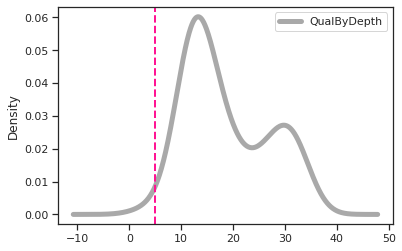

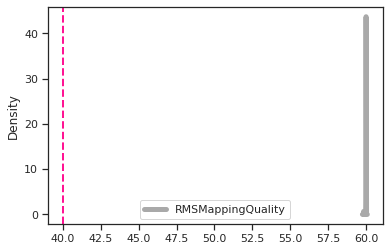

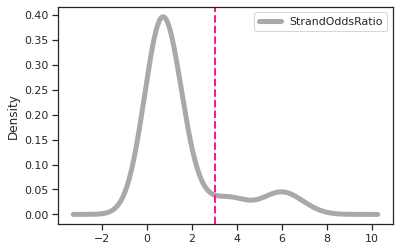

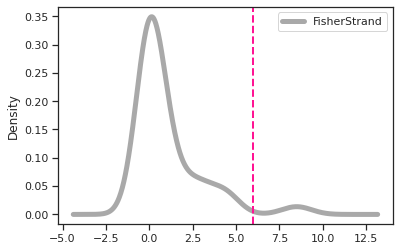

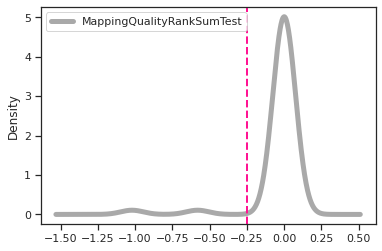

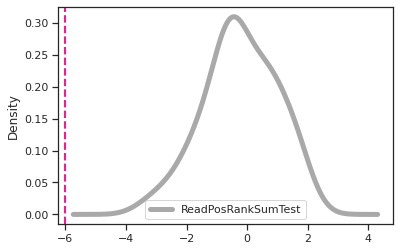

In [58]:
attrs = {"QD": "QualByDepth",
         "MQ":"RMSMappingQuality",
         "SOR":"StrandOddsRatio",
         "FS":"FisherStrand",
         "MQRankSum":"MappingQualityRankSumTest",
         "ReadPosRankSum":"ReadPosRankSumTest"
          }

cutoffs = {"QD": 5,
           "MQ":40,
           "SOR":3,
           "FS":6,
           "MQRankSum":-0.25,
           "ReadPosRankSum":-6
           }

for attr in attrs.keys():
    df = extract_attr(vcf_dict, vcf_info, attr, attrs[attr])
    df.plot.kde(color='darkgray', linewidth=5)
    plt.axvline(x=cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
    plt.show()

## Validation of Variants